# Regression with Orbit

In this notebook, we want to demonstartate how to use the different arguments in DLT model to realize different setups for the regressors. Those could be very useful in practice when tuning the models. Here includes two examples, one with the icliams dataset and one for the simulation data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams

from orbit.models.dlt import DLTFull
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components
from orbit.utils.simulation import make_regression
from orbit.constants.palette import QualitativePalette
from orbit.utils.dataset import load_iclaims
from orbit.diagnostics.metrics import smape

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import minmax_scale

rcParams['figure.figsize'] = 14, 8
plt.style.use('fivethirtyeight')

%matplotlib inline

## iclaims Data

*iclaims_example* is a dataset containing the weekly initial claims for US unemployment benefits against a few related google trend queries (unemploy, filling and job) from Jan 2010 - June 2018. This aims to mimick the dataset from the paper [Predicting the Present with Bayesian Structural Time Series](https://people.ischool.berkeley.edu/~hal/Papers/2013/pred-present-with-bsts.pdf) by SCOTT and VARIAN (2014).

Number of claims are obtained from [Federal Reserve Bank of St. Louis](https://fred.stlouisfed.org/series/ICNSA) while google queries are obtained through [Google Trends API](https://trends.google.com/trends/?geo=US).

In order to use this data to nowcast the US unemployment claims during COVID-19 period, we extended the dataset to Jan 2021 and added the [S&P 500 (^GSPC)](https://finance.yahoo.com/quote/%5EGSPC/history?period1=1264032000&period2=1611187200&interval=1wk&filter=history&frequency=1wk&includeAdjustedClose=true) and [VIX](https://finance.yahoo.com/quote/%5EVIX/history?p=%5EVIX) Index historical data for the same period.

The data is standardized and log-transformed for the model fitting purpose.

In [2]:
# load data
df = load_iclaims(end_date='2021-01-03')

df.dtypes

week              datetime64[ns]
claims                   float64
trend.unemploy           float64
trend.filling            float64
trend.job                float64
sp500                    float64
vix                      float64
dtype: object

In [3]:
df.head()

,week,claims,trend.unemploy,trend.filling,trend.job,sp500,vix
0,2010-01-03,13.386595,0.016351,-0.345855,0.130569,-0.543044,0.082087
1,2010-01-10,13.624218,0.016351,-0.222241,0.181862,-0.550891,0.069878
2,2010-01-17,13.398741,0.032611,-0.319879,0.130569,-0.590640,0.491772
3,2010-01-24,13.137549,-0.000179,-0.222241,0.119987,-0.607162,0.388078
4,2010-01-31,13.196760,-0.069172,-0.269869,0.087552,-0.614339,0.446838


We can see form the plot below, there are seasonlity trend and as well as a huge changpoint due the impact of COVID-19.

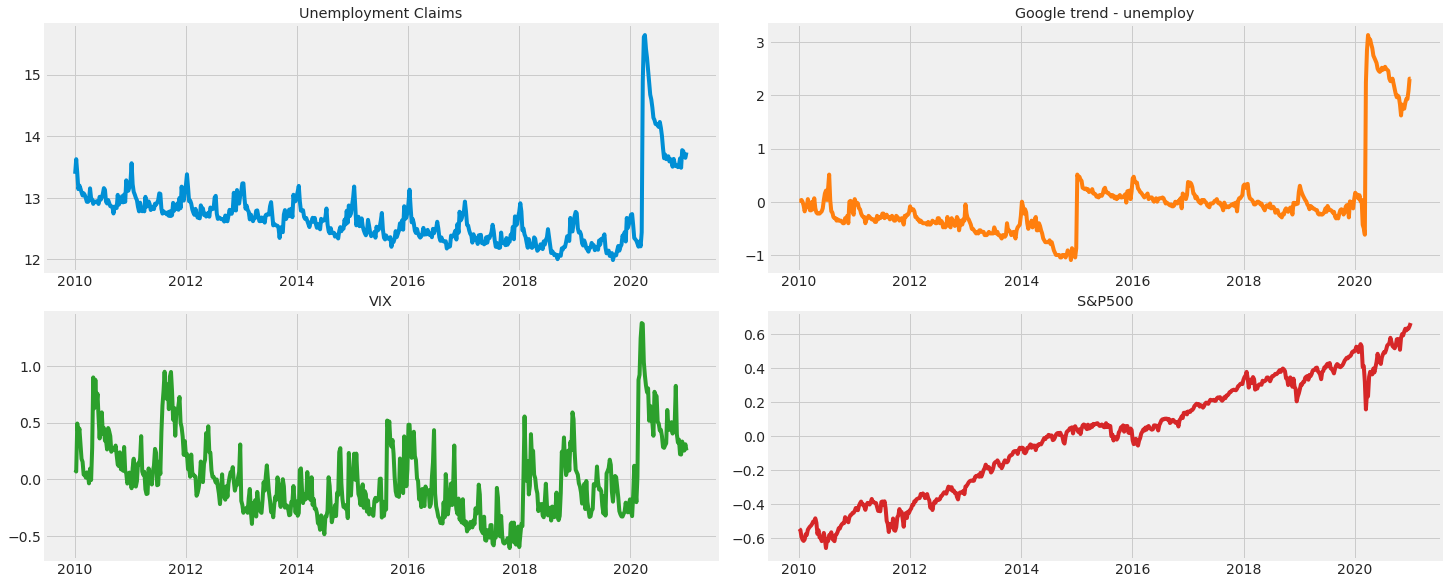

In [4]:
fig, axs = plt.subplots(2, 2,figsize=(20,8))
axs[0, 0].plot(df['week'], df['claims'])
axs[0, 0].set_title('Unemployment Claims')
axs[0, 1].plot(df['week'], df['trend.unemploy'], 'tab:orange')
axs[0, 1].set_title('Google trend - unemploy')
axs[1, 0].plot(df['week'], df['vix'], 'tab:green')
axs[1, 0].set_title('VIX')
axs[1, 1].plot(df['week'], df['sp500'], 'tab:red')
axs[1, 1].set_title('S&P500');

In [5]:
# split the dataset
# only use the data after 2018 as we observed from above chart that it has the more clear relationship between trend.unemploy and claims
df = df[df['week'] > '2018-01-01'].reset_index(drop=True)

test_size = 26

train_df = df[:-test_size]
test_df = df[-test_size:]

### Without Regression

We will use the DLT models here to compare the model performance without vs. with regression.

In [6]:
DATE_COL = 'week'
RESPONSE_COL = 'claims'

In [7]:
np.random.seed(8888)

In [8]:
dlt = DLTFull(response_col=RESPONSE_COL,
              date_col=DATE_COL,
              seasonality=52,
              seed=8888,
              num_warmup=4000,
              n_bootstrap_draws=4000)

In [9]:
%%time
dlt.fit(df=train_df)

CPU times: user 349 ms, sys: 145 ms, total: 495 ms
Wall time: 46.3 s


In [10]:
predicted_df = dlt.predict(df=test_df)

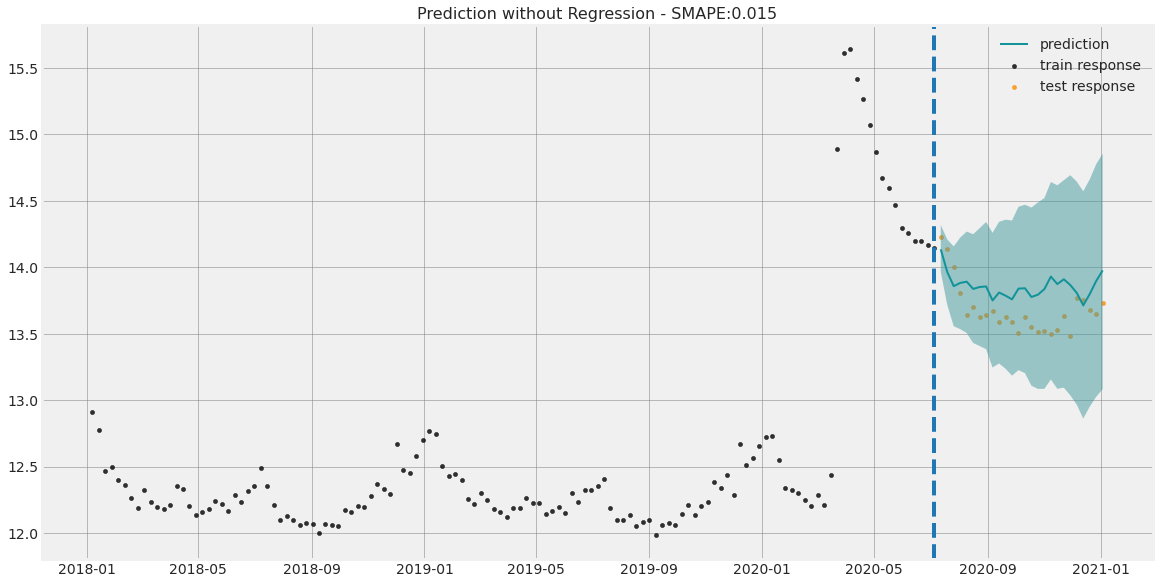

In [11]:
_ = plot_predicted_data(training_actual_df=train_df,
                        predicted_df=predicted_df, 
                        date_col=DATE_COL,
                        actual_col=RESPONSE_COL,  
                        test_actual_df=test_df,
                        title='Prediction without Regression - SMAPE:{:.3f}'.format(
                                smape(predicted_df['prediction'].values, test_df['claims'].values)
                            )
                       )

### With Regression

The regressor columns can be supplied via argument `regressor_col`. 

#### Regressor with the sign

In [12]:
REGRESSOR_COL = ['trend.unemploy', 'trend.filling', 'trend.job', 'sp500', 'vix']

dlt_reg = DLTFull(response_col=RESPONSE_COL, 
                  date_col=DATE_COL,
                  regressor_col=REGRESSOR_COL,
                  seasonality=52,
                  seed=8888,
                  num_warmup=4000,
                  n_bootstrap_draws=4000)


dlt_reg.fit(df=train_df)

The estimated regressor coefficients can be retrieved via `.get_regression_coefs()`.

In [13]:
dlt_reg.get_regression_coefs()

,regressor,regressor_sign,coefficient
0,trend.unemploy,Regular,0.844789
1,trend.filling,Regular,0.415170
2,trend.job,Regular,-0.000085
3,sp500,Regular,-0.441065
4,vix,Regular,0.053982


In [14]:
predicted_df_reg = dlt_reg.predict(test_df)

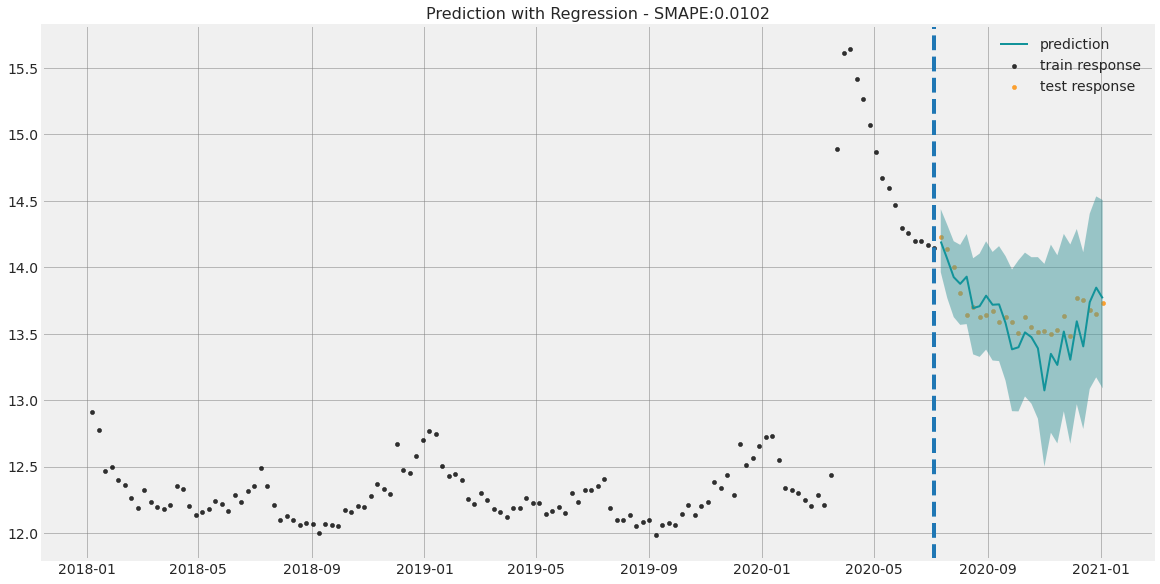

In [15]:
_ = plot_predicted_data(training_actual_df=train_df,
                        predicted_df=predicted_df_reg, 
                        date_col=DATE_COL,
                        actual_col=RESPONSE_COL,  
                        test_actual_df=test_df,
                        title='Prediction with Regression - SMAPE:{:.4f}'.format(
                                smape(predicted_df_reg['prediction'].values, test_df['claims'].values)
                            )
                       )

After adding the regressor, prediction results are more closer to the real response compared to without using regression. 

#### Adjust pirors for regressor beta and standard deviation

In the model, it is assumed $$\beta \sim Gaussian(\beta_{prior}, \sigma_{prior})$$

The default values for $\beta_{prior}$ and $\sigma_{prior}$ are 0 and 1, respectively.

Assuming users obtain further knowledge on each regressor, they could adjust prior knowledge on the coefficients via arguments `regressor_beta_prior` and `regressor_sigma_prior`. These two lists should be of the same lenght as `regressor_col`.

Also, assuming users have some prior knowledge on direction of impact by each regressor, users can specifiy them via `regressor_sign`, with a list of values consist '=' (regular, no restriction), '+' (positive) or '-' (negative). Such list should be of the same length. The default values of `regressor_sign` is all '='.

In [16]:
dlt_reg_adjust = DLTFull(response_col=RESPONSE_COL,
                         date_col=DATE_COL,
                         regressor_col=REGRESSOR_COL,
                         regressor_sign=["+", '+', '=', '-', '+'], 
                         regressor_beta_prior=[0.5, 0.25, 0.07, -0.3, 0.03],
                         regressor_sigma_prior=[0.05] * 5,
                         seasonality=52,
                         seed=8888,
                         num_warmup=4000,
                         n_bootstrap_draws=4000)


dlt_reg_adjust.fit(df=train_df)

In [17]:
dlt_reg_adjust.get_regression_coefs()

,regressor,regressor_sign,coefficient
0,trend.unemploy,Positive,0.455732
1,trend.filling,Positive,0.273449
2,vix,Positive,0.047058
3,sp500,Negative,-0.304073
4,trend.job,Regular,0.061556


In [18]:
predicted_df_reg_adjust = dlt_reg_adjust.predict(test_df)

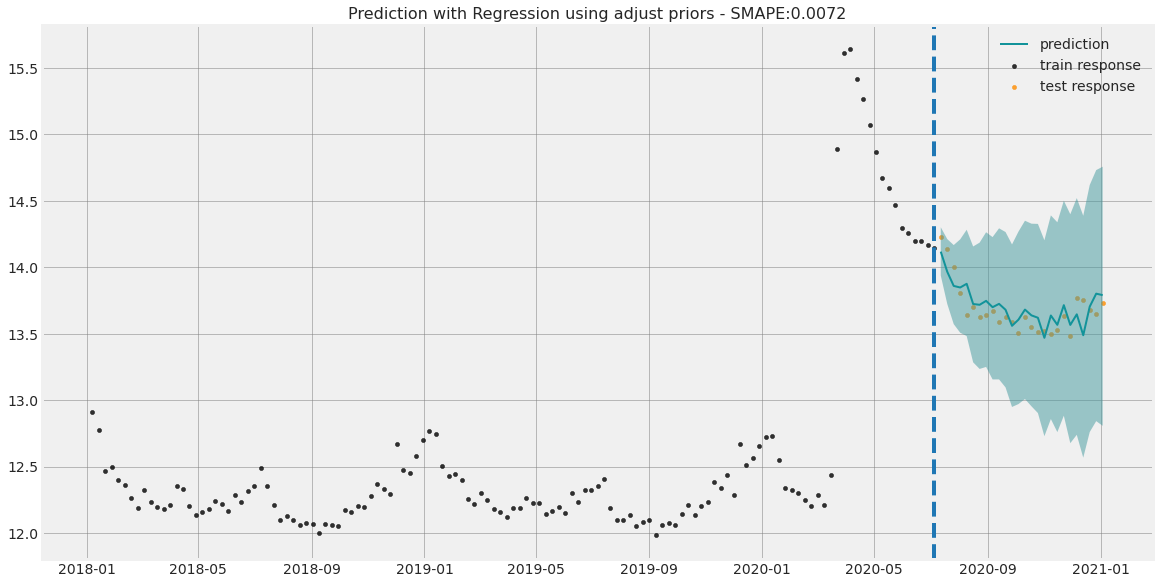

In [19]:
_ = plot_predicted_data(training_actual_df=train_df,
                        predicted_df=predicted_df_reg_adjust, 
                        date_col=DATE_COL,
                        actual_col=RESPONSE_COL,  
                        test_actual_df=test_df,
                        title='Prediction with Regression using adjust priors - SMAPE:{:.4f}'.format(
                        smape(predicted_df_reg_adjust['prediction'].values, test_df['claims'].values))
                       )

## Regression on Simulated Dataset

Leverage the simulation function to generate a dateset with regression terms

In [20]:
# To scale regressor values in a nicer way
SEED = 2020
NUM_OF_REGRESSORS = 5
COEFS = np.random.default_rng(SEED).normal(.03, .1, NUM_OF_REGRESSORS)

COEFS

array([ 0.15602066,  0.05231785,  0.16325487, -0.11182046,  0.0027203 ])

In [21]:
x, y, coefs = make_regression(200, COEFS, seed=SEED)

In [22]:
df = pd.DataFrame(x)
regressor_cols = [f"regressor_{x}" for x in range(1, NUM_OF_REGRESSORS + 1)]
df.columns = regressor_cols
#df[regressor_cols] = df[regressor_cols]/REG_BASE
#df[regressor_cols] = df[regressor_cols].apply(np.log1p)

# min max scale to avoid negetive values
response_col = "response"
df[response_col] = y 
df[response_col] = minmax_scale(df[response_col])

# add the date column
df['date'] = pd.date_range(start='2016-01-04', periods=200, freq="1W")

In [23]:
df.head()

,regressor_1,regressor_2,regressor_3,regressor_4,regressor_5,response,date
0,0.630103,0.111589,0.000000,-0.709102,-0.136399,0.724856,2016-01-10
1,0.000000,0.125509,0.136342,-0.880252,0.543985,0.535811,2016-01-17
2,-0.000000,0.292064,0.192392,0.000000,0.042711,0.713783,2016-01-24
3,0.666333,-0.000000,-0.240312,-0.408502,0.000000,0.248319,2016-01-31
4,0.593637,-0.256724,-0.000000,0.031756,0.546676,0.440959,2016-02-07


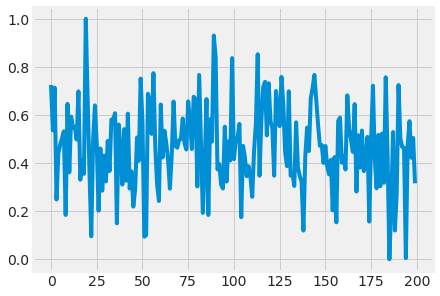

In [24]:
plt.plot(df['response']);

### Use data-driven sigma for each coefficients

Instead of using fixed standard deviations for regressors, a hyperprior can be assigned to them, i.e.
$$\sigma_\beta \sim \text{Half-Cauchy}(0, \text{ridge_scale})$$

This can be done by setting `regression_penalty="auto_ridge"`.  Notice there is a hyperprior `auto_ridge_scale` for tuning with a default of `0.5`. We can also supply stan config such as `adapt_delta` to reduce divergence see [here](https://mc-stan.org/rstanarm/reference/adapt_delta.html) for details.

In [25]:
mod_auto_ridge = DLTFull(response_col="response",
                         date_col="date",
                         regressor_col=regressor_cols,
                         seasonality=52,
                         seed=SEED,
                         regression_penalty='auto_ridge',
                         num_warmup=4000,
                         num_sample=1000,
                         stan_mcmc_control={'adapt_delta':0.9})


mod_auto_ridge.fit(df=df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [26]:
coef_auto_ridge = np.median(mod_auto_ridge._posterior_samples['beta'], axis=0)

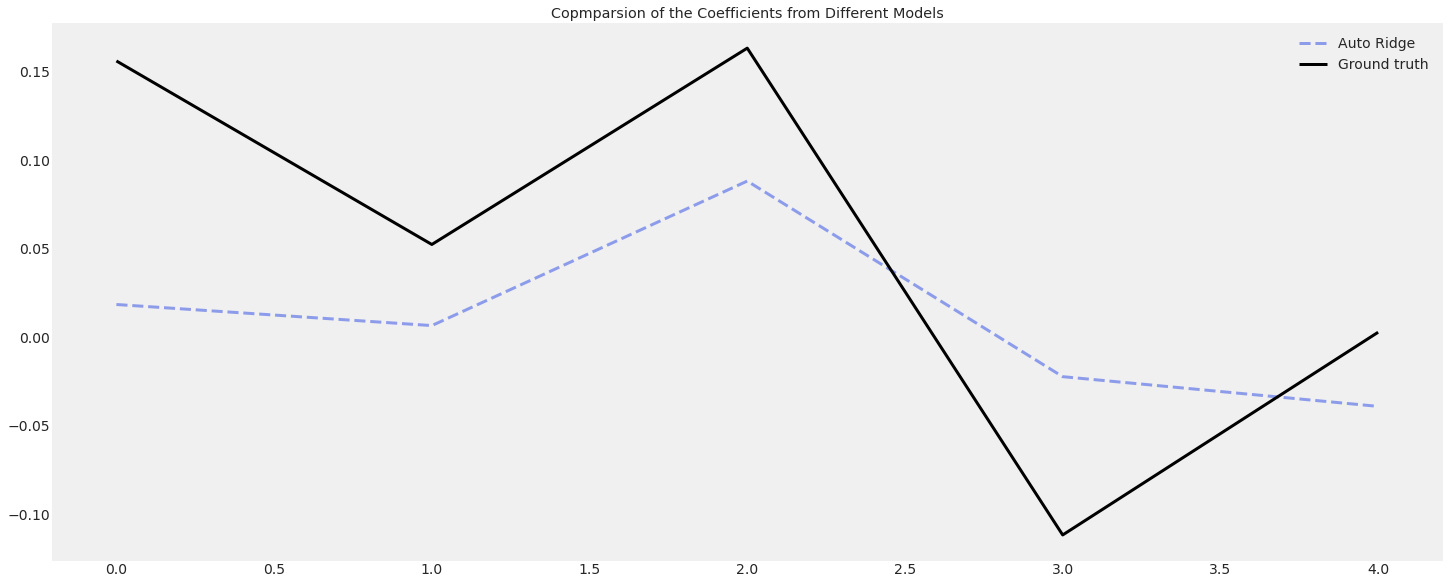

In [27]:
lw = 3
plt.figure(figsize=(20, 8))
plt.title("Copmparsion of the Coefficients from Different Models")
plt.plot(coef_auto_ridge, color=QualitativePalette.Line4.value[2], linewidth=lw, label="Auto Ridge", alpha=0.5, linestyle='--')
plt.plot(coefs, color="black", linewidth=lw, label="Ground truth")
plt.legend()
plt.grid()

The result looks reasonable comparing to the true coefficients.